### Tutorial [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

# DogNet


### Transfer learning approaches:
- **Finetuning the convnet (1)**: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.
- **ConvNet as fixed feature extractor (2)**: Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

In [7]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

plt.ion()   # interactive mode

### Load Data

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '_dataset_FPC'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Dataset sizes: ', dataset_sizes)
print('Class names: ', class_names)
print('Device: ', device)

Dataset sizes:  {'train': 10374, 'val': 517}
Class names:  ['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dalmatian', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog

### Visualize a few images

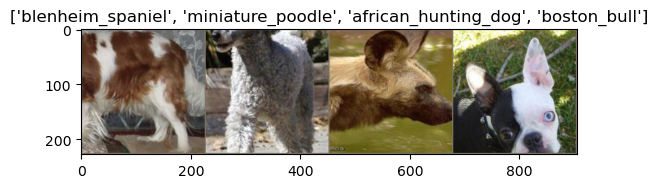

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Custom function to plot and save loss/accuracy graph

In [10]:
def train_val_plot(train_data, val_data, function_type, training_type):
    train_len = len(train_data)
    val_len = len(val_data)
    
    if train_len > 0 and val_len > 0:
        if torch.is_tensor(train_data[0]):
            for i in range(train_len):
                train_data[i] = train_data[i].cpu()
            
        if torch.is_tensor(val_data[0]):
            for i in range(val_len):
                val_data[i] = val_data[i].cpu()

        plt.plot(train_data,'-o')
        plt.plot(val_data,'-o')
        plt.xlabel('Epoch')
        plt.ylabel(function_type)
        plt.legend(['Train','Validation'])
        plt.title('Train vs Validation ' + str(function_type))

        # Save graph to .png
        plt.savefig('./saved_models/{0}_{1}.png'.format(function_type, training_type))
        
        # Show on screen
        plt.show()

### Training the model

In [11]:
def train_model(model, training_type, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    train_loss_vals = []
    train_acc_vals = []
    val_loss_vals = []
    val_acc_vals = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_acc_vals.append(epoch_acc)
                train_loss_vals.append(epoch_loss)
            else:
                val_acc_vals.append(epoch_acc)
                val_loss_vals.append(epoch_loss)
                
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    # Print train & validation loss
    train_val_plot(train_loss_vals, val_loss_vals, 'Losses', training_type)
    
    # Print train & validation accuracy
    train_val_plot(train_acc_vals, val_acc_vals, 'Accuracy', training_type)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions
Generic function to display predictions for a few images

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## <font color='blue'>**(1) Finetuning the convnet**</font> 
Load a pretrained model and reset final fully connected layer.

In [9]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train and evaluate

Epoch 0/24
----------
train Loss: 3.3422 Acc: 0.2074
val Loss: 1.9521 Acc: 0.4913

Epoch 1/24
----------
train Loss: 2.6168 Acc: 0.3344
val Loss: 1.8785 Acc: 0.5300

Epoch 2/24
----------
train Loss: 2.4101 Acc: 0.3825
val Loss: 1.6653 Acc: 0.5861

Epoch 3/24
----------
train Loss: 2.2967 Acc: 0.4139
val Loss: 1.6779 Acc: 0.5667

Epoch 4/24
----------
train Loss: 2.1707 Acc: 0.4387
val Loss: 1.5272 Acc: 0.6132

Epoch 5/24
----------
train Loss: 2.1132 Acc: 0.4553
val Loss: 1.7435 Acc: 0.5803

Epoch 6/24
----------
train Loss: 2.0162 Acc: 0.4767
val Loss: 1.5091 Acc: 0.6789

Epoch 7/24
----------
train Loss: 1.5638 Acc: 0.5898
val Loss: 1.0511 Acc: 0.7698

Epoch 8/24
----------
train Loss: 1.4321 Acc: 0.6238
val Loss: 0.9841 Acc: 0.7679

Epoch 9/24
----------
train Loss: 1.3692 Acc: 0.6348
val Loss: 0.9157 Acc: 0.7814

Epoch 10/24
----------
train Loss: 1.3140 Acc: 0.6499
val Loss: 0.9099 Acc: 0.7834

Epoch 11/24
----------
train Loss: 1.2836 Acc: 0.6610
val Loss: 0.9041 Acc: 0.8046

Ep

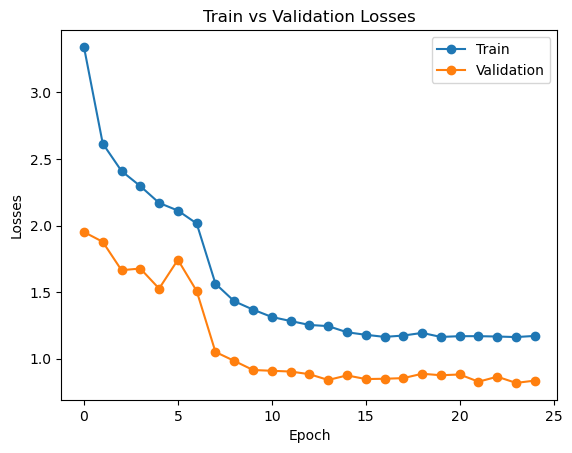

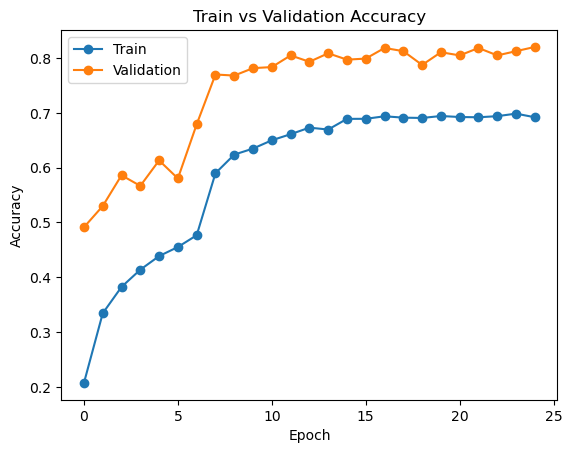

In [10]:
model_ft = train_model(model_ft, 'ft', criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

### Save model to path

In [11]:
torch.save(model_ft, './saved_models/model_ft.pt')

### Load model from path

In [13]:
model_ft = torch.load('./saved_models/model_ft.pt')

### Visualize model

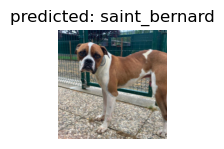

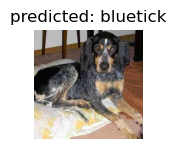

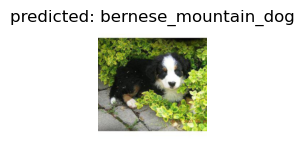

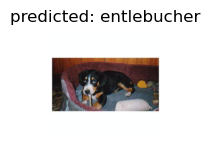

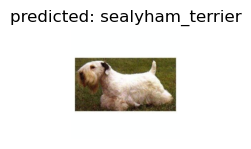

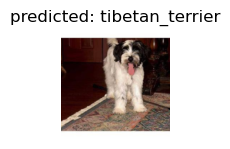

In [14]:
visualize_model(model_ft)

## <font color='blue'>**(2) ConvNet as fixed feature extractor**</font>
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

You can read more about this in the documentation [here](https://pytorch.org/docs/master/notes/autograd.html).

In [14]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Train and evaluate
On CPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

Epoch 0/24
----------
train Loss: 3.5209 Acc: 0.2076
val Loss: 1.4310 Acc: 0.6286

Epoch 1/24
----------
train Loss: 2.4624 Acc: 0.3948
val Loss: 1.2983 Acc: 0.6422

Epoch 2/24
----------
train Loss: 2.1860 Acc: 0.4465
val Loss: 1.1603 Acc: 0.6983

Epoch 3/24
----------
train Loss: 2.0549 Acc: 0.4714
val Loss: 1.1073 Acc: 0.7176

Epoch 4/24
----------
train Loss: 1.9679 Acc: 0.4922
val Loss: 1.0746 Acc: 0.7176

Epoch 5/24
----------
train Loss: 1.9232 Acc: 0.5056
val Loss: 1.0599 Acc: 0.7331

Epoch 6/24
----------
train Loss: 1.9120 Acc: 0.5046
val Loss: 1.0508 Acc: 0.7331

Epoch 7/24
----------
train Loss: 1.7141 Acc: 0.5608
val Loss: 0.9489 Acc: 0.7582

Epoch 8/24
----------
train Loss: 1.6918 Acc: 0.5635
val Loss: 1.0124 Acc: 0.7485

Epoch 9/24
----------
train Loss: 1.6778 Acc: 0.5701
val Loss: 0.9403 Acc: 0.7466

Epoch 10/24
----------
train Loss: 1.7037 Acc: 0.5617
val Loss: 0.9599 Acc: 0.7660

Epoch 11/24
----------
train Loss: 1.6791 Acc: 0.5736
val Loss: 1.0017 Acc: 0.7331

Ep

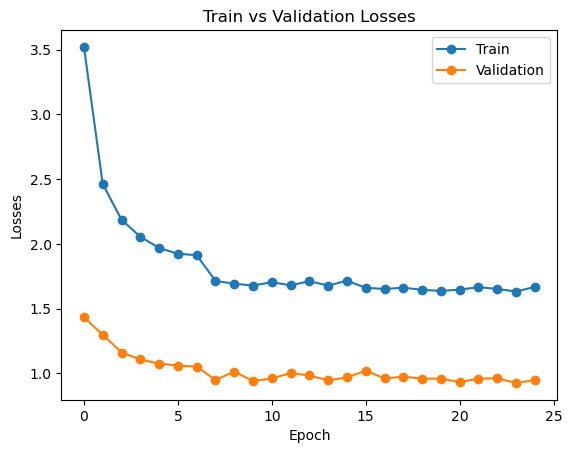

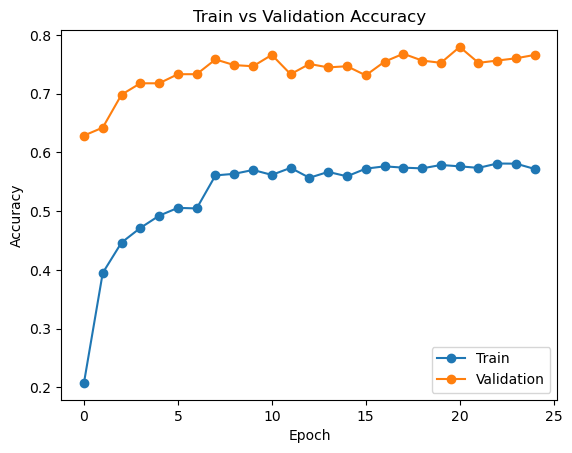

In [15]:
model_conv = train_model(model_conv, 'conv', criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

### Save model to path

In [16]:
torch.save(model_conv, './saved_models/model_conv.pt')

### Load model from path

In [15]:
model_conv = torch.load('./saved_models/model_conv.pt')

### Visualize model

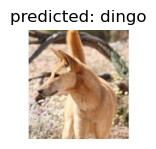

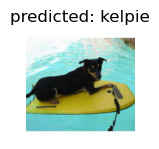

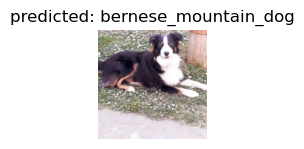

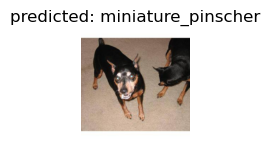

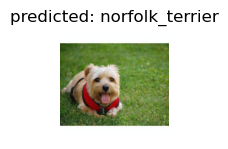

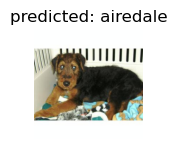

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [17]:
# Path useful for the next functions
img_to_predict_path = 'manual_test_images/english_springer_2.jpg'

<center><b> manual_test_images/english_springer_2.jpg </b></center>
<img src="manual_test_images/english_springer_2.jpg" width="200px" height="300px" />

### Predict one breed from one image

In [18]:
def predict_breed_from_img(model, input_img_path):
    img = Image.open(input_img_path)
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
        
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    
    batch_t = batch_t.to(device)

    outputs = model(batch_t)
    _, pred = torch.max(outputs, 1)

    return class_names[pred[0]]


breed_prediction = predict_breed_from_img(model_conv, img_to_predict_path)
print('Breed prediction: ', breed_prediction)

Breed prediction:  english_springer


### Get prediction values for each breed (for half-breed dog)

In [19]:
def get_breed_values_from_img(model, input_img_path):
    img = Image.open(input_img_path)
    
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
        
    img_t = transform(img)
    batch_t = torch.unsqueeze(img_t, 0)
    
    batch_t = batch_t.to(device)

    outputs = model(batch_t)

    return outputs


prediction_values = get_breed_values_from_img(model_conv, img_to_predict_path)
print('Predictions values: ', prediction_values)

Predictions values:  tensor([[-1.3015, -2.9350, -4.1926, -0.6989,  6.5262,  0.7577, -0.3748, -1.3335,
         -0.3991,  1.3485, -2.3694,  2.7241, -4.9723,  1.3723, -5.0156, -1.1445,
          1.5901,  2.5060, -3.7857,  4.8208, -2.4688,  0.6709, -1.5927, -0.8009,
          6.5210, -3.8518, -0.4748,  1.7573,  6.2687,  0.5635,  2.9113,  1.1412,
          5.2712,  1.4501,  0.4505, -3.8639, -1.1387, -4.7231, -0.4221, -3.4344,
         -3.9008, -1.1056,  9.7450, -1.3088,  3.6265,  2.9442,  0.2921, -3.1016,
          5.3916,  1.6407, -0.1135, -2.2021, -0.0244,  1.1050,  2.8900, -3.7036,
          0.3168,  0.7480,  0.5177,  2.4486, -0.8831,  1.8354, -4.6645, -1.5869,
          3.0200, -4.3198, -1.6796, -3.4723,  1.8332, -0.8656, -1.9834,  0.4975,
          3.3671, -3.3064, -4.5291, -2.8669, -0.5235, -0.6444,  0.9783,  0.5431,
          5.1491,  1.6067, -2.6080, -0.2167, -4.2159, -4.1198, -2.3455, -5.0312,
         -2.1419, -0.7447, -2.6213, -2.5396, -2.0905,  1.7944,  3.9287, -1.4490,
       

### Softmax to get percentage values

In [20]:
percentage_values = torch.nn.functional.softmax(prediction_values, dim=1)
print('Prediction values (percentage): ', percentage_values)

Prediction values (percentage):  tensor([[1.3447e-05, 2.6256e-06, 7.4652e-07, 2.4566e-05, 3.3742e-02, 1.0542e-04,
         3.3970e-05, 1.3024e-05, 3.3156e-05, 1.9033e-04, 4.6223e-06, 7.5327e-04,
         3.4234e-07, 1.9491e-04, 3.2783e-07, 1.5733e-05, 2.4235e-04, 6.0565e-04,
         1.1214e-06, 6.1311e-03, 4.1849e-06, 9.6657e-05, 1.0050e-05, 2.2185e-05,
         3.3566e-02, 1.0497e-06, 3.0739e-05, 2.8647e-04, 2.6081e-02, 8.6818e-05,
         9.0829e-04, 1.5471e-04, 9.6189e-03, 2.1070e-04, 7.7539e-05, 1.0370e-06,
         1.5824e-05, 4.3920e-07, 3.2401e-05, 1.5935e-06, 9.9954e-07, 1.6357e-05,
         8.4345e-01, 1.3349e-05, 1.8571e-03, 9.3867e-04, 6.6183e-05, 2.2226e-06,
         1.0850e-02, 2.5494e-04, 4.4117e-05, 5.4642e-06, 4.8228e-05, 1.4920e-04,
         8.8920e-04, 1.2174e-06, 6.7838e-05, 1.0441e-04, 8.2929e-05, 5.7186e-04,
         2.0434e-05, 3.0972e-04, 4.6570e-07, 1.0109e-05, 1.0126e-03, 6.5737e-07,
         9.2133e-06, 1.5341e-06, 3.0905e-04, 2.0795e-05, 6.7997e-06, 8.1271e

### Get the 2 higher values from predicted values (tensor) with related breeds

In [21]:
def get_2_higher_breeds(tensor_values):
    _, predictions = torch.topk(tensor_values, 2, sorted=True)
    preds = torch.squeeze(predictions).tolist()
    breed_1_name = class_names[preds[0]]
    breed_1_value = torch.squeeze(tensor_values).tolist()[preds[0]]


    breed_2_name = class_names[preds[1]]
    breed_2_value = torch.squeeze(tensor_values).tolist()[preds[1]]
    
    return {
        breed_1_name: breed_1_value,
        breed_2_name: breed_2_value
    }

two_b = get_2_higher_breeds(percentage_values)
print(two_b)

{'english_springer': 0.8434548377990723, 'american_staffordshire_terrier': 0.033742133527994156}


### Purebred or half-breed dog? (or no dogs?)
Heuristic to recognise if the dog is purebred of half-breed.
Input: the two higher values from the output values (in percentage format) with breed related.

In [22]:
def purebred_half_breed(obj):
    # obj must be a dict in the form:
    # {
    #    'breed_1': value,
    #    'breed_2': value
    # }
    # N.B. breed_1 value >= breed_1 value
    #
    #
    # return 'invalid', 'purebred', 'half_breed'
    
    keys = list(obj)
    
    percent1 = obj[keys[0]]
    percent2 = obj[keys[1]]
    
    limit = 1
    if (percent1 < 0.5):
        return 'invalid'
    else:
        if (percent1 >= 0.5 and percent1 < 0.6):
            limit = 0.25 # 25%
        elif (percent1 >= 0.6 and percent1 < 0.7):
            limit = 0.2 # 20%
        elif (percent1 >= 0.7 and percent1 < 0.8):
            limit = 0.15 # 15%
        elif (percent1 >= 0.8 and percent1 < 0.85):
            limit = 0.1 # 10%
        elif (percent1 >= 0.85 and percent1 < 0.9):
            limit = 0.07 # 7 %
        elif (percent1 >= 0.9 and percent1 < 0.95):
            limit = 0.04 # 4%

        if (percent2 >= limit):
            return 'half_breed'
        else:
            return 'purebred'

dog_type = purebred_half_breed(two_b)

keys = list(two_b)

if dog_type == 'invalid':
    print('No dogs found in the image or unknown dog breed.')
elif dog_type == 'purebred':
    print('Purebread dog found.\n\nBreed: {0}\nAccuracy: {1}%'
          .format(keys[0], round(two_b[keys[0]]*100, 1)))
elif dog_type == 'half_breed':
    print('Half-breed dog found.\n\nBreed 1: {0}\nAccuracy: {1}%\n\nBreed 2: {2}\nAccuracy: {3}%'
          .format(keys[0], round(two_b[keys[0]]*100, 1), keys[1], round(two_b[keys[1]]*100, 1)))
else:
    print('Unknown error ...')

Purebread dog found.

Breed: english_springer
Accuracy: 84.3%
